#WhatsApp Chat Analysis

###Importing libraries

In [2]:
!pip install emoji
!pip install heatmapz

     |████████████████████████████████| 174 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=6b28ab4e9baa8203f3a673cb6fab6f925125ed7b0bc28280215056bc0d690a74
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import datetime as dt
from matplotlib.ticker import MaxNLocator
import regex
import emoji
from seaborn import *
from heatmap import heatmap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import *
from plotly import express as px

###Function for preprocessing data

In [5]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

Regex pattern to extract username of Author

In [12]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

Extracting date, time, author and message from the chat file

In [7]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

Finally creating a dataframe and storing all data inside that dataframe

In [8]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversation = 'Data.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

###Importing dataset

In [9]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.

In [10]:
df.head()

,Date,Time,Author,Message
0,5/18/19,4:08 PM,None,"Rishabh created group ""Five ✋ Yaar🤭🤭🤭🤭🤭"""
1,5/23/19,4:58 PM,None,Samarth added you
2,5/23/19,5:01 PM,None,"Rishabh changed the subject from ""Five ✋ Yaar🤭..."
3,5/23/19,6:08 PM,Shubham,Pappy
4,5/23/19,6:19 PM,.,<Media omitted>


In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Time,Author,Message
0,2019-05-18,4:08 PM,None,"Rishabh created group ""Five ✋ Yaar🤭🤭🤭🤭🤭"""
1,2019-05-23,4:58 PM,None,Samarth added you
2,2019-05-23,5:01 PM,None,"Rishabh changed the subject from ""Five ✋ Yaar🤭..."
3,2019-05-23,6:08 PM,Shubham,Pappy
4,2019-05-23,6:19 PM,.,<Media omitted>


Checking shape of dataset

In [13]:
df.shape

(39545, 4)

Checking basic information of dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     39545 non-null  datetime64[ns]
 1   Time     39545 non-null  object        
 2   Author   38985 non-null  object        
 3   Message  39545 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.2+ MB


Checking no. of null values in dataset

In [15]:
df.isnull().sum()

Date         0
Time         0
Author     560
Message      0
dtype: int64

Dropping Nan values from dataset

In [16]:
df = df.dropna()
df = df.reset_index(drop = True)
df.shape

(38985, 4)

Checking no. of authors of group

In [17]:
df['Author'].nunique()

8

Checking authors of group

In [18]:
df['Author'].unique()

array(['Shubham', '.', 'Rishabh', 'Samarth', 'Ashish', '+91 82850 53130',
       'Kuldeep', 'Shubham:'], dtype=object)

Adding one more column of "Day" for better analysis, here we use datetiem library which help us to do this task easlily.

In [19]:
weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}

In [20]:
df['Day'] = df['Date'].dt.weekday.map(weeks)

Rearranging the columns for better understanding

In [21]:
df = df[['Date', 'Day', 'Time', 'Author', 'Message']]

Changing the datatype of column "day"

In [22]:
df['Day'] = df['Day'].astype('category')

Looking at newborn dataset

In [23]:
df.head()

,Date,Day,Time,Author,Message
0,2019-05-23,Thrusday,6:08 PM,Shubham,Pappy
1,2019-05-23,Thrusday,6:19 PM,.,<Media omitted>
2,2019-05-23,Thrusday,6:24 PM,Rishabh,😏😏
3,2019-05-23,Thrusday,6:24 PM,Rishabh,Daal m Khud ke
4,2019-05-23,Thrusday,6:27 PM,.,Teri to g***# tod dunga


Counting number of letters in each message

In [24]:
df["Letter's"] = df['Message'].apply(lambda s: len(s))

Counting number of word's in each message

In [25]:
df["Word's"] = df['Message'].apply(lambda s: len(s.split(' ')))

Function to count number of links in dataset, it will add extra column and store information in it.

In [26]:
URLPATTERN = r'(https?://S+)'

In [27]:
df['Url_Count'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.Url_Count)

Function to count number of media in chat.

In [28]:
MEDIAPATTERN = r'<Media omitted>'
df['Media_Count'] = df.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len()
media = np.sum(df.Media_Count)

Looking at updated dataset

In [29]:
df

,Date,Day,Time,Author,Message,Letter's,Word's,Url_Count,Media_Count
0,2019-05-23,Thrusday,6:08 PM,Shubham,Pappy,5,1,0,0
1,2019-05-23,Thrusday,6:19 PM,.,<Media omitted>,15,2,0,1
2,2019-05-23,Thrusday,6:24 PM,Rishabh,😏😏,2,1,0,0
3,2019-05-23,Thrusday,6:24 PM,Rishabh,Daal m Khud ke,14,4,0,0
4,2019-05-23,Thrusday,6:27 PM,.,Teri to g***# tod dunga,23,5,0,0
...,...,...,...,...,...,...,...,...,...
38980,2022-02-25,Friday,8:47 AM,Ashish,Agr free ho to bta Dena,23,6,0,0
38981,2022-02-25,Friday,8:47 AM,Rishabh,Acha,4,1,0,0
38982,2022-02-25,Friday,8:47 AM,Rishabh,Bta dege,8,2,0,0
38983,2022-02-25,Friday,8:47 AM,Ashish,12 bje tak,10,3,0,0


###Extracting basic statistics from the dataset

In [33]:
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
links = np.sum(df.Url_Count)
print('Group Chatting Stats : ')
print(f'Total Number of Messages : {total_messages}')
print(f'Total Number of Media Messages : {media_messages}')
print(f'Total Number of Links : {links}')

Group Chatting Stats : 
Total Number of Messages : 38985
Total Number of Media Messages : 3721
Total Number of Links : 0


###Extracting basic statistics of each user

In [34]:
l = df.Author.unique()
for i in range(len(l)):
  req_df = df[df["Author"] == l[i]]
  print(f'--> Stats of {l[i]} <-- ')
  print('Total Message Sent : ', req_df.shape[0])
  words_per_message = (np.sum(req_df["Word's"]))/req_df.shape[0]
  w_p_m = ("%.3f" % round(words_per_message, 2))  
  print('Average Words per Message : ', w_p_m)
  media = sum(req_df["Media_Count"])
  print('Total Media Message Sent : ', media)
  links = sum(req_df["Url_Count"])   
  print('Total Links Sent : ', links)   
  print()
  print('----------------------------------------------------------n')

--> Stats of Shubham <-- 
Total Message Sent :  10304
Average Words per Message :  3.310
Total Media Message Sent :  887
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of . <-- 
Total Message Sent :  3404
Average Words per Message :  3.730
Total Media Message Sent :  428
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Rishabh <-- 
Total Message Sent :  8005
Average Words per Message :  3.250
Total Media Message Sent :  286
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Samarth <-- 
Total Message Sent :  8978
Average Words per Message :  4.890
Total Media Message Sent :  1779
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Ashish <-- 
Total Message Sent :  7313
Average Words per Message :  4.030
Total Media Message Sent :  300
Total Links Sent :  0

--------------------------------------------------

###Let's create a word cloud of most used words in chat:

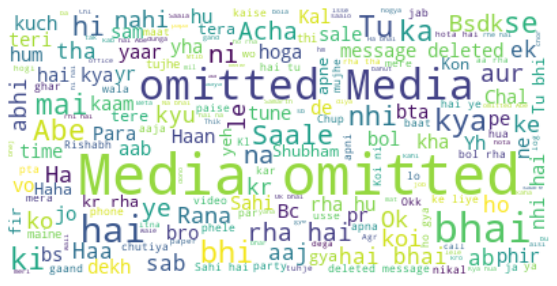

In [35]:
text = " ".join(review for review in df.Message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###Let's print the total no. of messages sent by each user:

In [36]:
l = df.Author.unique()
for i in range(len(l)):
  #Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  #req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Shubham   ->   10304
.   ->   3404
Rishabh   ->   8005
Samarth   ->   8978
Ashish   ->   7313
+91 82850 53130   ->   573
Kuldeep   ->   407
Shubham:   ->   1


###Let's print total messages sent on each day of the week

In [ ]:
l = df.Day.unique()
for i in range(len(l)):
  #Filtering out messages of particular user
  req_df = df[df["Day"] == l[i]]
  #req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Thrusday   ->   5807
Friday   ->   5443
Saturday   ->   5533
Sunday   ->   5340
Monday   ->   5592
Tuesday   ->   6021
Wednesday   ->   5249


*Finally, We have extracted sufficient text information from the chat file, now let’s start the Data Visualization part which will help us for better analysis and understanding the whole analysis that we have done on our exported chat file. At the place of contact numbers, I have used alphabets due to security purposes, really sorry for that.*

###Let’s check who is the mostly active author of the group :

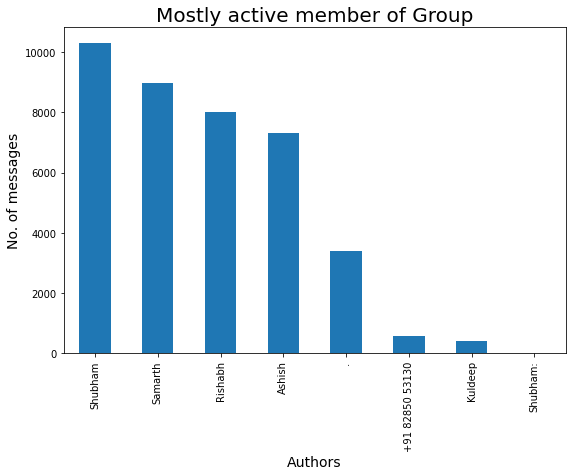

In [46]:
plt.figure(figsize=(9,6))
mostly_active = df['Author'].value_counts()

m_a = mostly_active.head(10)
bars = mostly_active.index
x_pos = np.arange(len(bars))
m_a.plot.bar()
plt.xlabel('Authors',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Mostly active member of Group',fontdict={'fontsize': 20,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()

###Let's check mostly active day in a week:

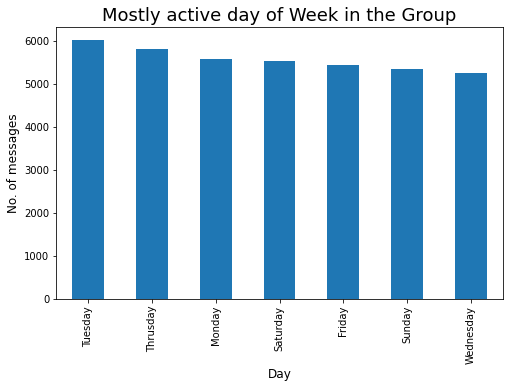

In [47]:
plt.figure(figsize=(8,5))
active_day = df['Day'].value_counts()

a_d = active_day.head(10)
a_d.plot.bar()
plt.xlabel('Day',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Mostly active day of Week in the Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

###Let’s check Top-10 media contributor in the group : 

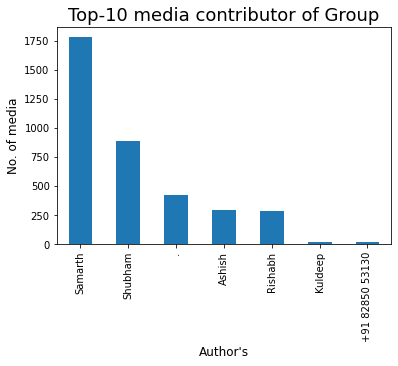

In [52]:
mm = df[df['Message'] == '<Media omitted>']
mm1 = mm['Author'].value_counts()
bars = mm1.index
x_pos = np.arange(len(bars))
top10 = mm1.head(10)
top10.plot.bar()
plt.xlabel("Author's",fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of media',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Top-10 media contributor of Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()

###Max word used by author:

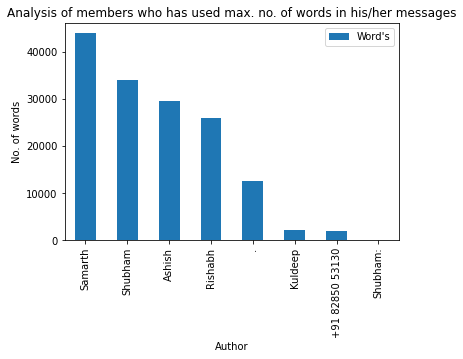

In [53]:
max_words = df[['Author',"Word's"]].groupby('Author').sum()
m_w = max_words.sort_values("Word's",ascending=False).head(10)
bars = m_w.index
x_pos = np.arange(len(bars))
m_w.plot.bar(rot=90)
plt.xlabel('Author')
plt.ylabel('No. of words')
plt.title('Analysis of members who has used max. no. of words in his/her messages')
plt.xticks(x_pos, bars)
plt.show()

###Let’s check the time whenever the group was highly active : 

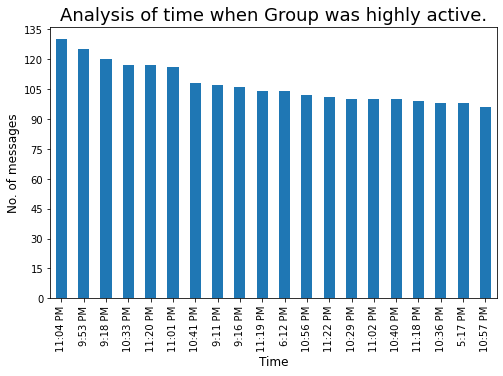

In [54]:
plt.figure(figsize=(8,5))
t = df['Time'].value_counts().head(20)
tx = t.plot.bar()
tx.yaxis.set_major_locator(MaxNLocator(integer=True))  
plt.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Analysis of time when Group was highly active.',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

###Let’s check the date on which our group was highly active : 

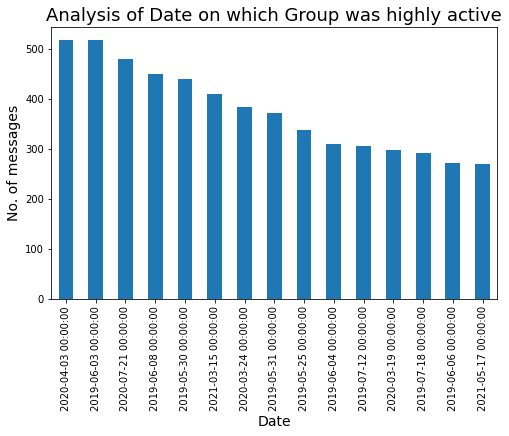

In [56]:
plt.figure(figsize=(8,5))
df['Date'].value_counts().head(15).plot.bar()
plt.xlabel('Date',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of Date on which Group was highly active',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

Converting 12-hour formate to 24 hours will help us for better analysis : 

In [78]:
lst = []
for i in df['Time'] :
  out_time = datetime.strftime(datetime.strptime(i,"%I:%M %p"),"%H:%M")
  lst.append(out_time)
df['24H_Time'] = lst
df['Hours'] = df['24H_Time'].apply(lambda x : x.split(':')[0])

###Let’s check the most suitable hour of the day whenever there will be more chances of getting a response from group members : 

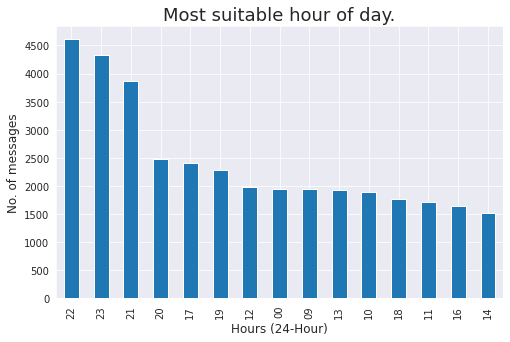

In [79]:
plt.figure(figsize=(8,5))
std_time = df['Hours'].value_counts().head(15)
s_T = std_time.plot.bar()
s_T.yaxis.set_major_locator(MaxNLocator(integer=True))  
plt.xlabel('Hours (24-Hour)',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Most suitable hour of day.',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

###Let’s create a time series plot w.r.t. no. of messages : 

In [58]:
z = df['Date'].value_counts() 
z1 = z.to_dict() 
df['Msg_count'] = df['Date'].map(z1)

fig = px.line(x=df['Date'],y=df['Msg_count'])
fig.update_layout(title="Analysis of number of message's using TimeSeries plot.",
                  xaxis_title='Month',
                  yaxis_title='No. of Messages')
fig.update_xaxes(nticks=20)
fig.show()

###Let’s create a separate column for Month and Year for better analysis :

In [59]:
df['Year'] = df['Date'].dt.year
df['Mon'] = df['Date'].dt.month
months = {
     1 : 'Jan',
     2 : 'Feb',
     3 : 'Mar',
     4 : 'Apr',
     5 : 'May',
     6 : 'Jun',
     7 : 'Jul',
     8 : 'Aug',
     9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'
}
df['Month'] = df['Mon'].map(months)
df.drop('Mon',axis=1,inplace=True)

###Let’s check mostly active month :

In [70]:
df['Month_Year'] = df['Month'] + ' ' + df['Year'].astype(str)

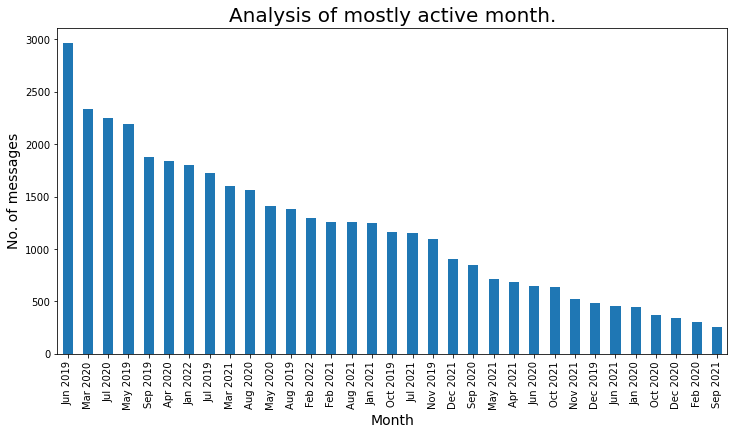

In [72]:
plt.figure(figsize=(12,6))
active_month = df['Month_Year'].value_counts()
a_m = active_month
a_m.plot.bar()
plt.xlabel('Month',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of mostly active month.',fontdict={'fontsize': 20,
        'fontweight': 8})
plt.show()

###Let’s analyze the most active month using a line plot : 

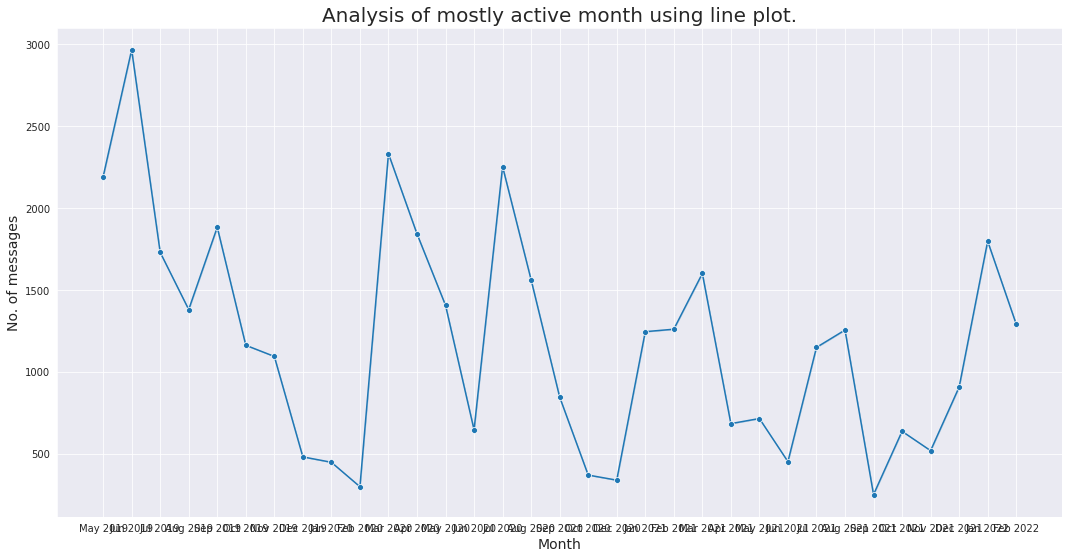

In [73]:
z = df['Month_Year'].value_counts() 
z1 = z.to_dict() 
df['Msg_count_monthly'] = df['Month_Year'].map(z1)
plt.figure(figsize=(18,9))
sns.set_style("darkgrid")
sns.lineplot(data=df,x='Month_Year',y='Msg_count_monthly',markers=True,marker='o')
plt.xlabel('Month',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of mostly active month using line plot.',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()

###Let’s check the total message per year :

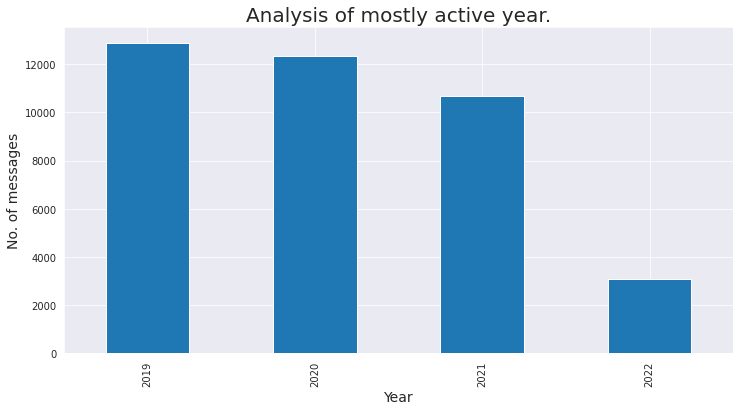

In [74]:
plt.figure(figsize=(12,6))
active_month = df['Year'].value_counts()
a_m = active_month
a_m.plot.bar()
plt.xlabel('Year',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of mostly active year.',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()

###Let’s use a heatmap and analyze highly active Day w.r.t. Time :

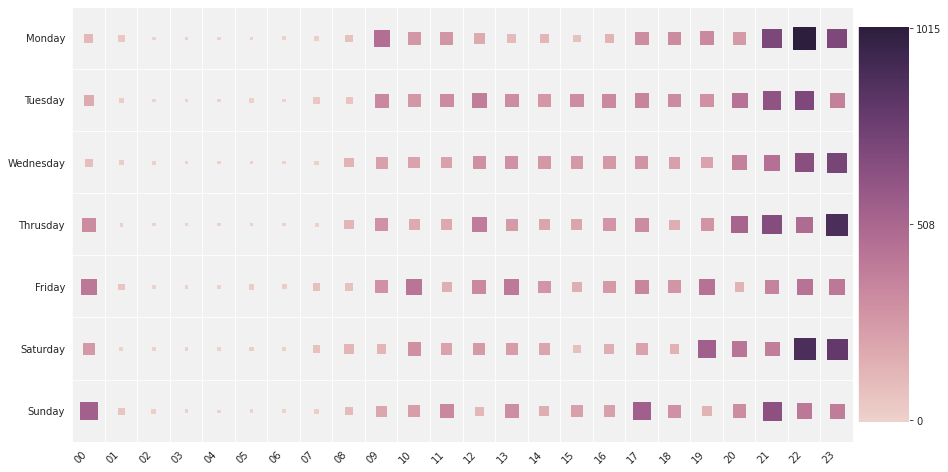

In [83]:
df2 = df.groupby(['Hours', 'Day'], as_index=False)["Message"].count()
df2 = df2.dropna()
df2.reset_index(drop = True,inplace = True)
analysis_2_df = df.groupby(['Hours', 'Day'], as_index=False)["Message"].count()
analysis_2_df.dropna(inplace=True)
analysis_2_df.sort_values(by=['Message'],ascending=False)
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15,8))
heatmap(
    x=analysis_2_df['Hours'],
    y=analysis_2_df['Day'],
    size_scale = 500,
    size = analysis_2_df['Message'], 
    y_order = day_of_week[::-1],
    color = analysis_2_df['Message'], 
    palette = sns.cubehelix_palette(128)
)
plt.show()

From the above heat map we analyze that on “Monday” between 21:00 to 22:59, our group was highly active, similarly on “Saturday” between 22:00 to 23:59, our group was highly active. Between 00:00 to 08:00 group was less active. 